# YOLOv7

### Enviroment

Stay in **directory yolov7** and install **enviroment python** with the libraries.

In [1]:
!ls

data_analysis.ipynb  look_annotations.py      README.md		ultralytics
images		     merge_data_video1.ipynb  train_yolo.ipynb	yolov7


In [2]:
%cd yolov7

/home/galois/Documents/galois2024/Aforo-vehicular/yolov7


/home/galois/Documents/galois2024/Aforo-vehicular/.env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
%%capture
%pip install -r requirements.txt

### Weights and test on img and video

Download weights of the model and test on video

In [3]:
%%capture
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt

In [4]:
# dowload img
!wget https://raw.githubusercontent.com/tkeldenich/How_to_use_YOLOv7_Tutorial/main/man_cafe.jpg

--2024-02-14 11:15:49--  https://raw.githubusercontent.com/tkeldenich/How_to_use_YOLOv7_Tutorial/main/man_cafe.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 47111 (46K) [image/jpeg]
Saving to: ‘man_cafe.jpg’

man_cafe.jpg        100%[===================>]  46,01K  --.-KB/s    in 0,02s   

2024-02-14 11:15:50 (2,40 MB/s) - ‘man_cafe.jpg’ saved [47111/47111]



In [5]:
# img
!python detect.py --weights yolov7-e6e.pt --source ./man_cafe.jpg

Namespace(weights=['yolov7-e6e.pt'], source='./man_cafe.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 89eda1a torch 2.2.0+cu121 CPU

Fusing layers... 
/home/galois/Documents/galois2024/Aforo-vehicular/.env/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 792 layers, 151687420 parameters, 817020 gradients, 210.5 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

2 persons, 1 cup, 1 tv, 2 laptops, 1 cell phone, 1 book, Done. (3415.4ms) Inference, (17.6ms) NMS
 The image 

In [8]:
# video
#!python detect.py --weights yolov7-e6e.pt --conf 0.25 --source ./video1_test.mp4

# Setting to Fine-Tuning YOLOv7

In [9]:
%cd ..

/home/galois/Documents/galois2024/Aforo-vehicular


/home/galois/Documents/galois2024/Aforo-vehicular/.env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
!ls

data		     look_annotations.py      train_yolo.ipynb
data_analysis.ipynb  merge_data_video1.ipynb  videos
images		     README.md		      yolov7


In [32]:
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import json
from collections import Counter
import numpy as np


### DataSet

La data es formato yolo y para probar el modelo se usa solo anotaciones realizadas en CVAT. La data .zip descargada tiene:
* obj_train_data: contiene un .txt por cada frame, en el archivo esta las clases detectadas y el box.
* obj.data : informacion de rutas y clases
* obj.names : las clases
* train.txt : contiene la ruta de cada frame data/obj_train_data/frame_029972.PNG

## annotations .json

In [12]:
data = json.load(open("./data/FineTuned_YOLO/annotations/video1_data/instances_default.json"))

In [13]:
data.keys()

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])

In [14]:
data["categories"]

[{'id': 1, 'name': 'Auto Privado', 'supercategory': ''},
 {'id': 2, 'name': 'Bus', 'supercategory': ''},
 {'id': 3, 'name': 'Camioneta rural', 'supercategory': ''},
 {'id': 4, 'name': 'Microbus', 'supercategory': ''},
 {'id': 5, 'name': 'Mototaxi', 'supercategory': ''},
 {'id': 6, 'name': 'Moto lineal', 'supercategory': ''},
 {'id': 7, 'name': 'Omnibus Interprovincial', 'supercategory': ''},
 {'id': 8, 'name': 'Auto colectivo', 'supercategory': ''},
 {'id': 9, 'name': 'Articulado', 'supercategory': ''}]

In [15]:
print(len(data["images"]))
print(len(data["annotations"]))

30139
10170


In [16]:
data["annotations"][0]

{'id': 1,
 'image_id': 1,
 'category_id': 1,
 'segmentation': [],
 'area': 18745.05680000002,
 'bbox': [1680.1, 363.13, 115.34, 162.52],
 'iscrowd': 0,
 'attributes': {'occluded': False, 'rotation': 0.0}}

In [17]:
img_with_annotation = [i["image_id"] for i in data["annotations"]]

## Redimension and save img

In [19]:
cap = cv2.VideoCapture("./data/videos/video1.mp4")
_,frame = cap.read()
r = frame.shape[0]/frame.shape[1] # H/W
new_W = frame.shape[1]/5
dim = (int(new_W), int(r * new_W))

In [20]:
cap = cv2.VideoCapture("./data/videos/video1.mp4")
count = 1
set_img = set(img_with_annotation)
success, frame = cap.read()
while success:
    name = "./data/FineTuned_YOLO/images/frame_" + str(count) + ".png"
    if count in set_img:
        resized = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
        cv2.imwrite(name,resized)  # SAVE IMG
    success, frame = cap.read()
    count = count + 1
cap.release()

In [38]:
#np.unique(categori_id, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([2613, 2035, 1914,  111,  110, 1415,   61, 1060,  851]))

(216, 384, 3)


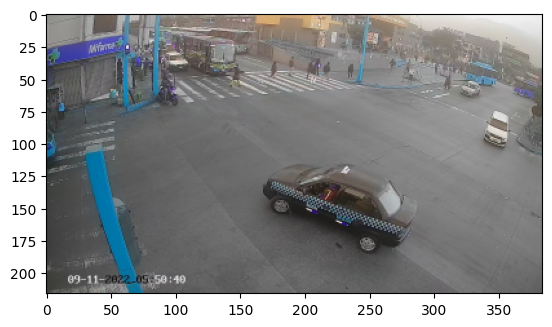

In [22]:
img = cv2.imread("./data/FineTuned_YOLO/images/frame_1.png")
print(img.shape)
H,W,_ = img.shape
H = float(H)
W = float(W)
plt.imshow(img)

## Transform and redimention of annotations

In [23]:
Ho = 1080
Wo = 1920

In [24]:
def coco_to_yolo(coco_bbox, image_width=W, image_height=H):
    x_min, y_min, width, height = coco_bbox
    
    # COCO format to YOLO format
    center_x = (x_min + width / 2) / image_width
    center_y = (y_min + height / 2) / image_height
    yolo_width = width / image_width
    yolo_height = height / image_height
    
    return [center_x, center_y, yolo_width, yolo_height]

def yolo_to_coco(yolo_bbox, image_width=W, image_height=H):
    center_x, center_y, yolo_width, yolo_height = yolo_bbox
    
    # YOLO format to COCO format
    x_min = int((center_x - yolo_width / 2) * image_width)
    y_min = int((center_y - yolo_height / 2) * image_height)
    width = int(yolo_width * image_width)
    height = int(yolo_height * image_height)
    
    return [x_min, y_min, width, height]

In [25]:
data["annotations"][1]["bbox"]

[516.21, 74.78, 214.95, 164.27]

In [26]:
for i in data["annotations"]:
    f = open("./data/FineTuned_YOLO/labels/frame_"+str(i["image_id"])+".txt", "a")
    f.write(str(int(i["category_id"]-1))+ " ")
    
    # cl,x,y,w,h = [eval(i) for i in boxx] YOLO
    # # Bboxes are in [top-left-x, top-left-y, width, height]  COCO
    box = coco_to_yolo(i["bbox"])

    # due of resized
    box[0] = box[0]*W/Wo
    box[1] = box[1]*H/Ho
    box[2] = box[2]*W/Wo
    box[3] = box[3]*H/Ho
    
    for b in box:
        f.write( f"{b:.5f}" + " ")
    f.write("\n")
    f.close()

## See img and box from annotations

In [27]:
W

384.0

In [65]:
def oslistdir(directory):
    def get_creation_time(entry):
        return entry.stat().st_ctime

    with os.scandir(directory) as entries:
        sorted_entries = sorted(entries, key=get_creation_time)
        sorted_items = [entry.name for entry in sorted_entries]
    return sorted_items

In [69]:
names = []
for i in oslistdir("./data/FineTuned_YOLO/images"):
    i = i.split(".")[0]
    names.append(i)

In [71]:
# CREATE VIDEO WITH IMG WITH ANNOTATIONS
img_array = []
for name in names:
    img = cv2.imread("./data/FineTuned_YOLO/images/" + name + ".png")
    box=[]
    with open("./data/FineTuned_YOLO/labels/" + name + ".txt", "r") as f:
        for i in f:
            box.append(i.split())
    f.close()

    for boxx in box:
    
        cl,x,y,w,h = [eval(i) for i in boxx]

        h_frame,w_frame,channel = frame.shape

        # top left
        xtl = int(x*w_frame-w*w_frame/2)
        ytl = int(y*h_frame+h*h_frame/2)

        # bottom right
        xbr = int(x*w_frame+w*w_frame/2)
        ybr = int(y*h_frame-h*h_frame/2)

        img = cv2.rectangle(img, (xtl,ytl),(xbr,ybr),(0,255,0),2 )


    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

out = cv2.VideoWriter("./videos/video1_low.mp4",cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),  1, size)


for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

box : class, x, y, w, h 
 [['5', '0.24391', '0.27837', '0.04990', '0.12945'], ['8', '0.35803', '0.11707', '0.14460', '0.13010'], ['0', '0.95526', '0.29463', '0.02655', '0.05506'], ['2', '0.91986', '0.30083', '0.04930', '0.10333'], ['1', '0.87670', '0.21069', '0.06702', '0.09552'], ['1', '0.32381', '0.14575', '0.11251', '0.14608'], ['0', '0.27198', '0.17720', '0.05815', '0.08091']]


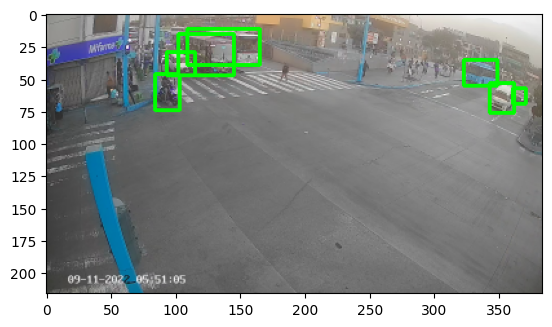

In [72]:
frame = cv2.imread("./data/FineTuned_YOLO/images/frame_621.png").copy()
box = []
with open("./data/FineTuned_YOLO/labels/frame_621.txt", "r") as f:
    for i in f:
        box.append(i.split())
print("box : class, x, y, w, h \n", box)
f.close()

for boxx in box:
    
    cl,x,y,w,h = [eval(i) for i in boxx]

    h_frame,w_frame,channel = frame.shape

    # top left
    xtl = int(x*w_frame-w*w_frame/2)
    ytl = int(y*h_frame+h*h_frame/2)

    # bottom right
    xbr = int(x*w_frame+w*w_frame/2)
    ybr = int(y*h_frame-h*h_frame/2)

    frame = cv2.rectangle(frame, (xtl,ytl),(xbr,ybr),(0,255,0),2 )

plt.imshow(frame)
plt.show()

### Create: Test, Train, Val directories

In [73]:
labels = os.listdir("./data/FineTuned_YOLO/labels")
per_train = 80
per_val = 10
train_labels = labels[0:int((len(labels) * per_train)/100)]
val_labels = labels[int((len(labels) * per_train)/100):int((len(labels) * (per_train+per_val))/100)]
test_labels = labels[int(len(labels) * (per_val+per_train)/100):]

In [74]:
print("total : ", len(labels))
print("train : ", len(train_labels))
print("test  : ", len(test_labels))
print("val   : ", len(val_labels))

total :  1861
train :  1488
test  :  187
val   :  186


In [75]:
# copy images to train, val and test folders
for label in train_labels:
    filename = label.split(".")[0]
    #path = os.getcwd()
    # images source and destination path
    img_src = './data/FineTuned_YOLO/images/'+filename+'.png'
    img_dst = './data/FineTuned_YOLO/Train/images/'+filename+'.png'
    # labels source and destination path
    label_src = './data/FineTuned_YOLO/labels/'+filename+'.txt'
    label_dst = './data/FineTuned_YOLO/Train/labels/'+filename+'.txt'
    
    shutil.copy(img_src, img_dst)
    shutil.copy(label_src, label_dst)

for label in val_labels:
    filename = label.split(".")[0]
    #path = os.getcwd()
    # images source and destination path
    img_src = './data/FineTuned_YOLO/images/'+filename+'.png'
    img_dst = './data/FineTuned_YOLO/Val/images/'+filename+'.png'
    # labels source and destination path
    label_src = './data/FineTuned_YOLO/labels/'+filename+'.txt'
    label_dst = './data/FineTuned_YOLO/Val/labels/'+filename+'.txt'
    
    shutil.copy(img_src, img_dst)
    shutil.copy(label_src, label_dst)

for label in test_labels:
    filename = label.split(".")[0]
    #path = os.getcwd()
    # images source and destination path
    img_src = './data/FineTuned_YOLO/images/'+filename+'.png'
    img_dst = './data/FineTuned_YOLO/Test/images/'+filename+'.png'
    # labels source and destination path
    label_src = './data/FineTuned_YOLO/labels/'+filename+'.txt'
    label_dst = './data/FineTuned_YOLO/Test/labels/'+filename+'.txt'
    
    shutil.copy(img_src, img_dst)
    shutil.copy(label_src, label_dst)